In [1]:
import os
import glob
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Model
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet,VGG16,VGG19, MobileNetV2, ResNet50, ResNet101,ResNet152, InceptionV3,InceptionResNetV2,DenseNet121,DenseNet169,DenseNet201,Xception,NASNetMobile, NASNetLarge
from keras.applications.inception_v3 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
DATA_PATH = "/kaggle/input/preprocess-dataset-augmentation/AD_AUG"

Dataset shape: (12020, 2)


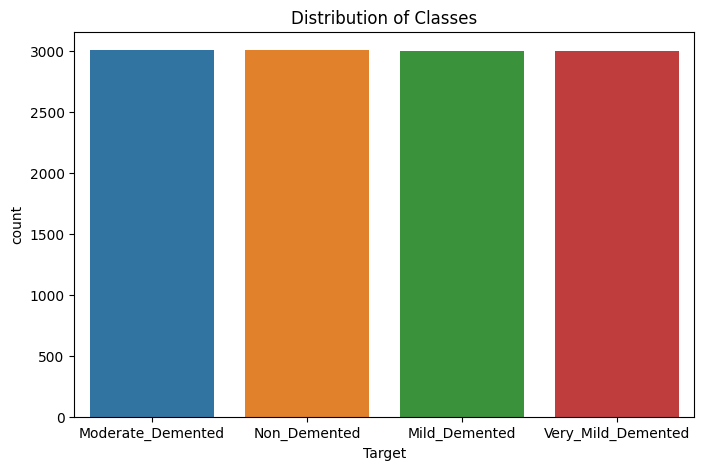

In [3]:
def load_data(data_path):
    all_paths = glob.glob(f'{data_path}/**/*.*', recursive=True)
    labels = [os.path.split(os.path.split(path)[0])[1] for path in all_paths]
    return pd.DataFrame({'Filepath': all_paths, 'Target': labels}).sample(frac=1).reset_index(drop=True)

dataframe = load_data(DATA_PATH)
def explore_data(df):
    print("Dataset shape:", df.shape)
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x='Target')
    plt.title("Distribution of Classes")
    plt.show()
    dataframe = load_data(DATA_PATH)
explore_data(dataframe)

In [6]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocessing: Grayscale,Denoising,CLAHE,Resize,Rescale
#Local Binary Pattern (LBP) for feature extraction

def preprocess_image(filepath):

    image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

    image = cv2.fastNlMeansDenoising(image, None, 10, 7, 21)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply(image)

    image = cv2.resize(image, (128, 128))

    image = image / 255.0

    lbp = local_binary_pattern(image, P=8, R=1, method="uniform")

    return lbp

In [7]:
def prepare_data(df):

    datagen = ImageDataGenerator(validation_split=0.2)

    def custom_image_loader(filepath):
        processed_image = preprocess_image(filepath)
        return np.expand_dims(processed_image, axis=-1)

    train_data = datagen.flow_from_dataframe(
        df, x_col='Filepath', y_col='Target', target_size=(128, 128), batch_size=16, subset='training',
        class_mode='categorical', shuffle=True,
        preprocessing_function=custom_image_loader
    )
    test_data = datagen.flow_from_dataframe(
        df, x_col='Filepath', y_col='Target', target_size=(128, 128), batch_size=16, subset='validation',
        class_mode='categorical', shuffle=False,
        preprocessing_function=custom_image_loader
    )

    return train_data, test_data


train_data, test_data = prepare_data(dataframe)

Found 9616 validated image filenames belonging to 4 classes.
Found 2404 validated image filenames belonging to 4 classes.


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27            │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 4, 4, 512)      │     14,714,688 │ input_layer_27[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg19 (Functional)        │ (None, 4, 4, 512)      │     20,024,384 │ input_layer_27[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_25 (Flatten)      │ (None, 8192)           │              0 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_26 (Flatten)      │ (None, 8192)           │              0 │ vgg19[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_14            │ (None, 16384)          │              0 │ flatten_25[0][0],      │
│ (Concatenate)             │                        │                │ flatten_26[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_28 (Dense)          │ (None, 1024)           │     16,778,240 │ concatenate_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 1024)           │              0 │ dense_28[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_29 (Dense)          │ (None, 512)            │        524,800 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 512)            │              0 │ dense_29[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_30 (Dense)          │ (None, 4)              │          2,052 │ dropout_9[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 52,044,164 (198.53 MB)

 Trainable params: 17,305,092 (66.01 MB)

 Non-trainable params: 34,739,072 (132.52 MB)

Epoch 1/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.5048 - loss: 6.6098 - val_accuracy: 0.8819 - val_loss: 0.3121
Epoch 2/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.7511 - loss: 0.7147 - val_accuracy: 0.8968 - val_loss: 0.2862
Epoch 3/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.8229 - loss: 0.4874 - val_accuracy: 0.9239 - val_loss: 0.2000
Epoch 4/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.8622 - loss: 0.3929 - val_accuracy: 0.9405 - val_loss: 0.1634
Epoch 5/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.8791 - loss: 0.3521 - val_accuracy: 0.9451 - val_loss: 0.1564
Epoch 6/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.9032 - loss: 0.2693 - val_accuracy: 0.9576 - val_loss: 0.1204
Epoch 7/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.9046 - loss: 0.2594 - val_accuracy: 0.9443 - val_loss: 0.1738
Epoch 8/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.9173 - loss: 0.2309 - 

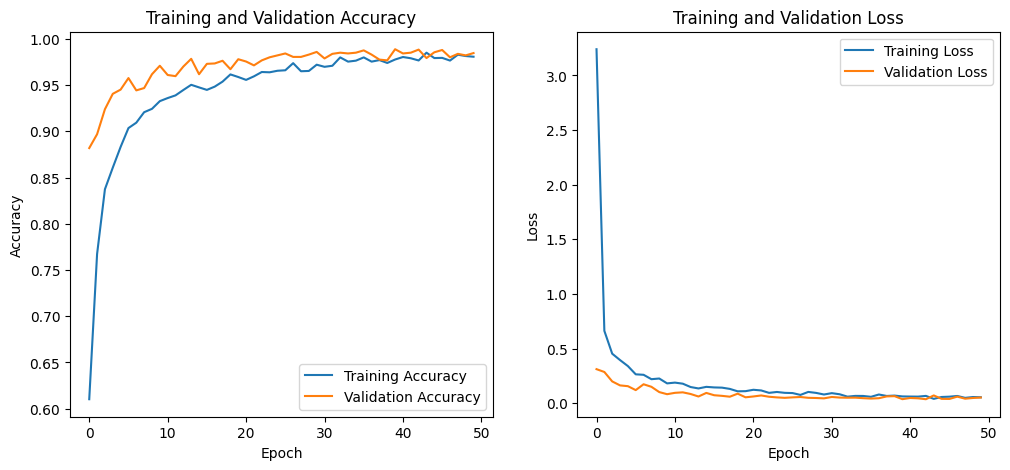

151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step
Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.97      0.99      0.98       613
 Moderate_Demented       1.00      1.00      1.00       583
      Non_Demented       0.98      1.00      0.99       626
Very_Mild_Demented       1.00      0.95      0.97       582

          accuracy                           0.98      2404
         macro avg       0.99      0.98      0.98      2404
      weighted avg       0.98      0.98      0.98      2404



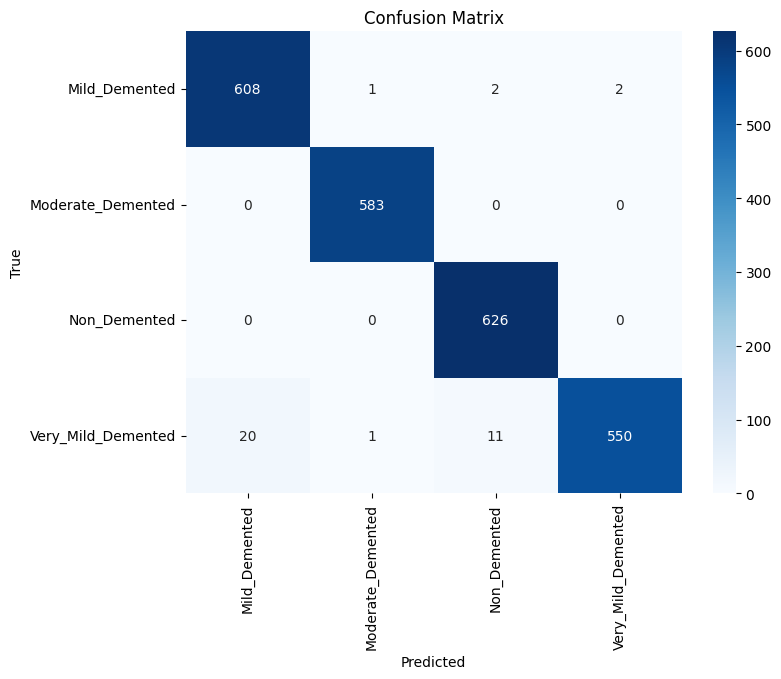

In [33]:
from keras.layers import Input, Concatenate, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.optimizers import Adam

# Load VGG16 and VGG19 models without the top layers
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers of VGG16 and VGG19
for layer in vgg16.layers:
    layer.trainable = False

for layer in vgg19.layers:
    layer.trainable = False

# Create the hybrid model
input_layer = Input(shape=(128, 128, 3))

# Get the output of VGG16 and VGG19
vgg16_output = vgg16(input_layer)
vgg19_output = vgg19(input_layer)

# Flatten the outputs
vgg16_output = Flatten()(vgg16_output)
vgg19_output = Flatten()(vgg19_output)

# Concatenate the outputs
merged = Concatenate()([vgg16_output, vgg19_output])

# Add additional layers
x = Dense(1024, activation='relu')(merged)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(train_data.class_indices), activation='softmax')(x)

# Create the final model
hybrid_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
hybrid_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
hybrid_model.summary()

# Train the model
history = hybrid_model.fit(
    train_data,
    validation_data=test_data,
    epochs=50,
    batch_size=16
)

# Evaluate the model
loss, accuracy = hybrid_model.evaluate(test_data)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Generate predictions
y_pred = hybrid_model.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)

# Get the true labels
y_true = test_data.classes

# Generate classification report
class_names = list(train_data.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


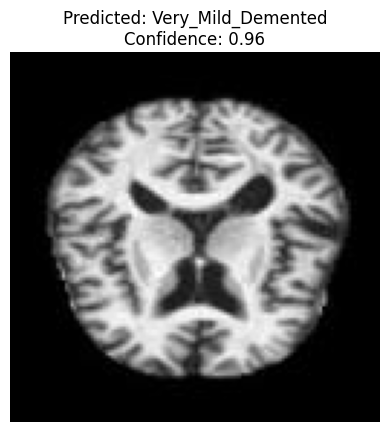

Predicted Class: Very_Mild_Demented
Confidence: 0.96


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to preprocess a single image for prediction
def preprocess_image_for_prediction(filepath):
    img = image.load_img(filepath, target_size=(128, 128))  # Resize to match model input size
    img_array = image.img_to_array(img)  # Convert to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Rescale to [0, 1]
    return img_array

# Function to predict an image
def predict_image(model, filepath, class_names):
    # Preprocess the image
    img_array = preprocess_image_for_prediction(filepath)
    
    # Make prediction
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class = class_names[predicted_class_index]
    confidence = np.max(predictions)
    
    # Display the image and prediction
    img = image.load_img(filepath, target_size=(128, 128))
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}")
    plt.axis('off')
    plt.show()
    
    return predicted_class, confidence

# Get class names from the train_data generator
class_names = list(train_data.class_indices.keys())

# Select a random image from the test data
random_index = np.random.randint(0, len(test_data.filepaths))
random_image_path = test_data.filepaths[random_index]

# Predict the image
predicted_class, confidence = predict_image(hybrid_model, random_image_path, class_names)
print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")


**HYBRID MODEL **
